In [74]:
from dotenv import load_dotenv
import pandas as pd
from pathlib import Path
import pprint
from IPython.display import Image

from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import os
import re
import html
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

from typing import TypedDict, List, Annotated, Optional, Literal
from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod
import operator
import nest_asyncio
from IPython.display import Image, display

load_dotenv()

True

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [24]:
from openai import OpenAI
client = OpenAI()
model = "gpt-5-mini"
# response = client.responses.create(
#     model=model,
#     input="What is today's date?",
# )

# print(response.output_text)

In [5]:
project_root = Path.cwd()
data_folder = project_root / "data"
print(project_root)
print(data_folder)

c:\Users\yq198\Desktop\DANNY_AI\Agentic_PR\notebook
c:\Users\yq198\Desktop\DANNY_AI\Agentic_PR\notebook\data


In [42]:
bbc_data_df = pd.read_csv("../data/bbc-news-data.csv", sep='\t', on_bad_lines='warn')
taylor_swift_df = pd.read_csv("../data/TaylorSwift13.csv")

In [43]:
print(bbc_data_df.info())
print(taylor_swift_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   content         756 non-null    object 
 1   created_at      756 non-null    object 
 2   date            756 non-null    object 
 3   likeCount       756 non-null    int64  
 4   media           404 non-null    object 
 5   outlinks        756 non-null    object 
 6   quoteCount      756 non-null    int64  
 7   quotedTweet     70 non-null     object 
 8   replyCount      756 non-null    int64  
 9   retweetCount   

In [44]:
#  BBC EDA

In [45]:
pprint.pprint(bbc_data_df.iloc[0]["content"])
pprint.pprint(bbc_data_df.iloc[0])
len(bbc_data_df.iloc[0]["content"])

(' Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn '
 '(£600m) for the three months to December, from $639m year-earlier.  The '
 'firm, which is now one of the biggest investors in Google, benefited from '
 'sales of high-speed internet connections and higher advert sales. TimeWarner '
 'said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were '
 'buoyed by one-off gains which offset a profit dip at Warner Bros, and less '
 'users for AOL.  Time Warner said on Friday that it now owns 8% of '
 'search-engine Google. But its own internet business, AOL, had has mixed '
 'fortunes. It lost 464,000 subscribers in the fourth quarter profits were '
 "lower than in the preceding three quarters. However, the company said AOL's "
 'underlying profit before exceptional items rose 8% on the back of stronger '
 'internet advertising revenues. It hopes to increase subscribers by offering '
 'the online service free to TimeWarner internet customers and will tr

2525

In [46]:
print(bbc_data_df["category"].unique())
print(bbc_data_df["category"].value_counts())
print(bbc_data_df.isna().sum()) # no NA as well
print(bbc_data_df["content"].duplicated().sum())
# all news have category metadata good to our advantage

['business' 'entertainment' 'politics' 'sport' 'tech']
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64
category    0
filename    0
title       0
content     0
dtype: int64
133


In [47]:
bbc_data_df[bbc_data_df[["title","content"]].duplicated()==True]


,category,filename,title,content
239,business,240.txt,Economy 'strong' in election year,UK businesses are set to prosper during the n...
252,business,253.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
332,business,333.txt,Troubled Marsh under SEC scrutiny,The US stock market regulator is investigatin...
355,business,356.txt,S Korea spending boost to economy,South Korea will boost state spending next ye...
370,business,371.txt,Singapore growth at 8.1% in 2004,"Singapore's economy grew by 8.1% in 2004, its..."
...,...,...,...,...
2205,tech,382.txt,Tough rules for ringtone sellers,Firms that flout rules on how ringtones and o...
2210,tech,387.txt,Progress on new internet domains,By early 2005 the net could have two new doma...
2211,tech,388.txt,Camera phones are 'must-haves',Four times more mobiles with cameras in them ...
2216,tech,393.txt,Savvy searchers fail to spot ads,Internet search engine users are an odd mix o...


In [48]:
bbc_data_df_clean = bbc_data_df[bbc_data_df[["title","content"]].duplicated()==False]
bbc_data_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2127 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2127 non-null   object
 1   filename  2127 non-null   object
 2   title     2127 non-null   object
 3   content   2127 non-null   object
dtypes: object(4)
memory usage: 83.1+ KB


In [49]:
pprint.pprint(bbc_data_df_clean.iloc[1]["content"])
pprint.pprint(bbc_data_df_clean.iloc[1])
len(bbc_data_df_clean.iloc[1]["content"])

(' The dollar has hit its highest level against the euro in almost three '
 'months after the Federal Reserve head said the US trade deficit is set to '
 "stabilise.  And Alan Greenspan highlighted the US government's willingness "
 'to curb spending and rising household savings as factors which may help to '
 'reduce it. In late trading in New York, the dollar reached $1.2871 against '
 'the euro, from $1.2974 on Thursday. Market concerns about the deficit has '
 'hit the greenback in recent months. On Friday, Federal Reserve chairman Mr '
 "Greenspan's speech in London ahead of the meeting of G7 finance ministers "
 'sent the dollar higher after it had earlier tumbled on the back of '
 'worse-than-expected US jobs data. "I think the chairman\'s taking a much '
 "more sanguine view on the current account deficit than he's taken for some "
 'time," said Robert Sinche, head of currency strategy at Bank of America in '
 'New York. "He\'s taking a longer-term view, laying out a set of con

2219

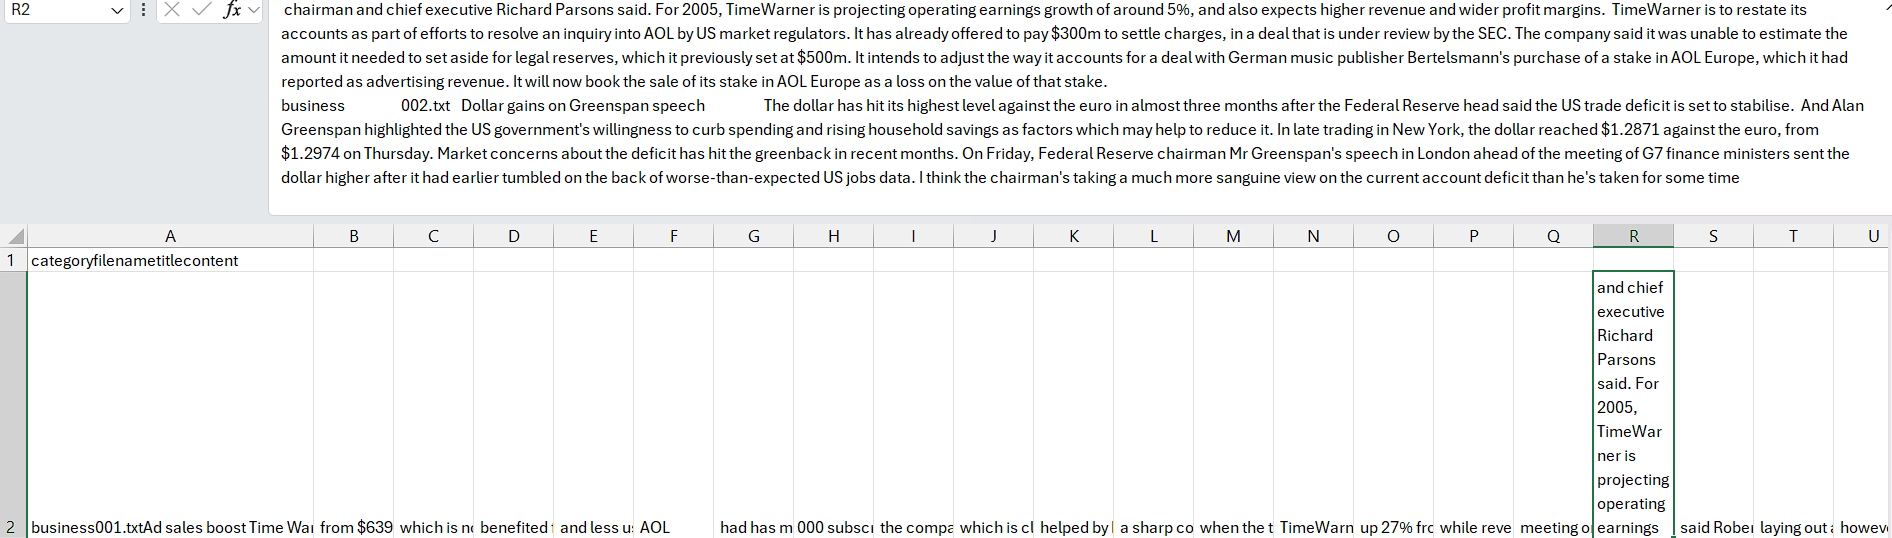

In [50]:
# Within same meta data business001.txt, sometimes contains other news as well like business 002.txt inside - thankfully pandas helps to correct this
Image(filename="../image/mixed_content_within_other_content.png")



In [51]:
# Find out max and average number of words within the longest article
word_counts = bbc_data_df_clean["content"].str.split().str.len()

# 2. Get the maximum value
max_words = word_counts.max()
avg_words = word_counts.mean()

print(f"The longest article has {max_words} words.")
print(f"The average article length is {avg_words:.2f} words.")

The longest article has 4428 words.
The average article length is 378.92 words.


In [52]:
def audit_article_lengths(df, column_name="content"):
    # Calculate word counts
    word_counts = df[column_name].str.split().str.len()
    
    # Create masks for thresholds
    over_2k = word_counts[word_counts > 2000]
    over_4k = word_counts[word_counts > 4000]
    
    print(f"--- Dataset Audit: {column_name} ---")
    print(f"Total Articles: {len(df)}")
    print(f"Articles > 2,000 words: {len(over_2k)} ({len(over_2k)/len(df):.2%})")
    print(f"Articles > 4,000 words: {len(over_4k)} ({len(over_4k)/len(df):.2%})")
    
    if not over_4k.empty:
        print(f"Max word count found: {over_4k.max()}")
        
    return word_counts

# Run it on your BBC dataframe
bbc_word_counts = audit_article_lengths(bbc_data_df_clean)

--- Dataset Audit: content ---
Total Articles: 2127
Articles > 2,000 words: 7 (0.33%)
Articles > 4,000 words: 1 (0.05%)
Max word count found: 4428


In [53]:
bbc_data_df_clean

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2219,tech,396.txt,New consoles promise big problems,Making games for future consoles will require...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [54]:
# 1 document = 1 chunk based on above findings
# Not nessarily to over complicate and engineer special strategy just for 0.31% of the articles that are over 2k words.
# 99.69% of articles can be fully chunked via 1 doc each

# MOVING ON TO NEXT SET OF DATA

In [55]:
# Taylorswift DF EDA

In [56]:
taylor_swift_df

,content,created_at,date,likeCount,media,outlinks,quoteCount,quotedTweet,replyCount,retweetCount,retweetedTweet,url,id,conversationId
0,Thanks for all the beautiful wishes today!! I ...,Tue Dec 13 23:07:26 +0000 2022,2022-12-13 23:07:26+00:00,602625,[Photo(previewUrl='https://pbs.twimg.com/media...,[],24562,NaN,22331,96825,NaN,https://twitter.com/taylorswift13/status/16028...,1602802403492995072,1602802403492995072
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,Tue Nov 15 17:17:51 +0000 2022,2022-11-15 17:17:51+00:00,32877,NaN,[],1708,NaN,2521,3115,NaN,https://twitter.com/taylorswift13/status/15925...,1592567568191356930,1592503899759394818
2,Anti hero but make it acoustic 🥲\n\nNow at htt...,Fri Nov 11 00:31:01 +0000 2022,2022-11-11 00:31:01+00:00,228241,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],8938,NaN,7083,23829,NaN,https://twitter.com/taylorswift13/status/15908...,1590864637356310528,1590864637356310528
3,Take your self loathing to the dancefloor! 2 m...,Thu Nov 10 19:01:05 +0000 2022,2022-11-10 19:01:05+00:00,161916,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],11507,NaN,5755,17477,NaN,https://twitter.com/taylorswift13/status/15907...,1590781606918524929,1590781606918524929
4,The anti hero (Roosevelt remix) makes me feel ...,Wed Nov 09 22:21:38 +0000 2022,2022-11-09 22:21:38+00:00,111888,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,['http://store.taylorswift.com'],1619,NaN,2434,13768,NaN,https://twitter.com/taylorswift13/status/15904...,1590469691864018945,1590469691864018945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,@David_Henrie The sad thing is that I thought ...,Tue Mar 17 03:02:30 +0000 2009,2009-03-17 03:02:30+00:00,305,NaN,[],9,NaN,10,175,NaN,https://twitter.com/taylorswift13/status/13401...,1340188809,1340175748
752,@David_Henrie Oh... so I guess Dave's Faves wo...,Tue Mar 17 02:55:11 +0000 2009,2009-03-17 02:55:11+00:00,167,NaN,[],0,NaN,4,92,NaN,https://twitter.com/taylorswift13/status/13401...,1340155876,1340146480
753,@David_Henrie How about... Hen's Friends. haha...,Tue Mar 17 02:46:17 +0000 2009,2009-03-17 02:46:17+00:00,292,NaN,[],5,NaN,47,111,NaN,https://twitter.com/taylorswift13/status/13401...,1340116239,1340097258
754,"@johncmayer Mine: ""My diary is read by everyone.""",Tue Mar 17 02:33:52 +0000 2009,2009-03-17 02:33:52+00:00,524,NaN,[],19,NaN,32,470,NaN,https://twitter.com/taylorswift13/status/13400...,1340060849,1339917932


In [57]:
def determine_category(text):
    text = text.lower()
    
    # Music Keywords
    music_keywords = ['album', 'tour', 'song', 'music', 'concert', 'track', 'vinyl', 'studio', 'lyrics']
    if any(word in text for word in music_keywords):
        return "music"
    
    # Personal Keywords
    personal_keywords = ['cat', 'family', 'home', 'love you', 'friends', 'birthday', 'mom', 'dad']
    if any(word in text for word in personal_keywords):
        return "personal"
    
    # Default to Lifestyle
    return "lifestyle"

# Apply to your dataframe
taylor_swift_df['category'] = taylor_swift_df['content'].apply(determine_category)

In [58]:
taylor_swift_df.head()

,content,created_at,date,likeCount,media,outlinks,quoteCount,quotedTweet,replyCount,retweetCount,retweetedTweet,url,id,conversationId,category
0,Thanks for all the beautiful wishes today!! I ...,Tue Dec 13 23:07:26 +0000 2022,2022-12-13 23:07:26+00:00,602625,[Photo(previewUrl='https://pbs.twimg.com/media...,[],24562,NaN,22331,96825,NaN,https://twitter.com/taylorswift13/status/16028...,1602802403492995072,1602802403492995072,music
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,Tue Nov 15 17:17:51 +0000 2022,2022-11-15 17:17:51+00:00,32877,NaN,[],1708,NaN,2521,3115,NaN,https://twitter.com/taylorswift13/status/15925...,1592567568191356930,1592503899759394818,lifestyle
2,Anti hero but make it acoustic 🥲\n\nNow at htt...,Fri Nov 11 00:31:01 +0000 2022,2022-11-11 00:31:01+00:00,228241,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],8938,NaN,7083,23829,NaN,https://twitter.com/taylorswift13/status/15908...,1590864637356310528,1590864637356310528,lifestyle
3,Take your self loathing to the dancefloor! 2 m...,Thu Nov 10 19:01:05 +0000 2022,2022-11-10 19:01:05+00:00,161916,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],11507,NaN,5755,17477,NaN,https://twitter.com/taylorswift13/status/15907...,1590781606918524929,1590781606918524929,lifestyle
4,The anti hero (Roosevelt remix) makes me feel ...,Wed Nov 09 22:21:38 +0000 2022,2022-11-09 22:21:38+00:00,111888,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,['http://store.taylorswift.com'],1619,NaN,2434,13768,NaN,https://twitter.com/taylorswift13/status/15904...,1590469691864018945,1590469691864018945,lifestyle


In [59]:
def clean_tweet_text(text):
    # 1. Decode HTML entities (e.g., convert &amp; to &)
    text = html.unescape(text)
    
    # 2. Remove URLs (http, https, and t.co links)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 3. Remove HTML tags (if any like <br>, <div>)
    text = re.sub(r'<.*?>', '', text)
    
    # 4. Clean up extra whitespace
    text = " ".join(text.split())
    
    return text

In [60]:
taylor_swift_df["content"] = taylor_swift_df['content'].apply(clean_tweet_text)

In [61]:
taylor_swift_df[["content", "category"]]

,content,category
0,Thanks for all the beautiful wishes today!! I ...,music
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,lifestyle
2,Anti hero but make it acoustic 🥲 Now at,lifestyle
3,Take your self loathing to the dancefloor! 2 m...,lifestyle
4,The anti hero (Roosevelt remix) makes me feel ...,lifestyle
...,...,...
751,@David_Henrie The sad thing is that I thought ...,lifestyle
752,@David_Henrie Oh... so I guess Dave's Faves wo...,lifestyle
753,@David_Henrie How about... Hen's Friends. haha...,personal
754,"@johncmayer Mine: ""My diary is read by everyone.""",lifestyle


In [62]:
# remove duplicates
taylor_swift_df = taylor_swift_df[taylor_swift_df[["content", "category"]].duplicated() == False]
taylor_swift_df

,content,created_at,date,likeCount,media,outlinks,quoteCount,quotedTweet,replyCount,retweetCount,retweetedTweet,url,id,conversationId,category
0,Thanks for all the beautiful wishes today!! I ...,Tue Dec 13 23:07:26 +0000 2022,2022-12-13 23:07:26+00:00,602625,[Photo(previewUrl='https://pbs.twimg.com/media...,[],24562,NaN,22331,96825,NaN,https://twitter.com/taylorswift13/status/16028...,1602802403492995072,1602802403492995072,music
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,Tue Nov 15 17:17:51 +0000 2022,2022-11-15 17:17:51+00:00,32877,NaN,[],1708,NaN,2521,3115,NaN,https://twitter.com/taylorswift13/status/15925...,1592567568191356930,1592503899759394818,lifestyle
2,Anti hero but make it acoustic 🥲 Now at,Fri Nov 11 00:31:01 +0000 2022,2022-11-11 00:31:01+00:00,228241,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],8938,NaN,7083,23829,NaN,https://twitter.com/taylorswift13/status/15908...,1590864637356310528,1590864637356310528,lifestyle
3,Take your self loathing to the dancefloor! 2 m...,Thu Nov 10 19:01:05 +0000 2022,2022-11-10 19:01:05+00:00,161916,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],11507,NaN,5755,17477,NaN,https://twitter.com/taylorswift13/status/15907...,1590781606918524929,1590781606918524929,lifestyle
4,The anti hero (Roosevelt remix) makes me feel ...,Wed Nov 09 22:21:38 +0000 2022,2022-11-09 22:21:38+00:00,111888,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,['http://store.taylorswift.com'],1619,NaN,2434,13768,NaN,https://twitter.com/taylorswift13/status/15904...,1590469691864018945,1590469691864018945,lifestyle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,@David_Henrie The sad thing is that I thought ...,Tue Mar 17 03:02:30 +0000 2009,2009-03-17 03:02:30+00:00,305,NaN,[],9,NaN,10,175,NaN,https://twitter.com/taylorswift13/status/13401...,1340188809,1340175748,lifestyle
752,@David_Henrie Oh... so I guess Dave's Faves wo...,Tue Mar 17 02:55:11 +0000 2009,2009-03-17 02:55:11+00:00,167,NaN,[],0,NaN,4,92,NaN,https://twitter.com/taylorswift13/status/13401...,1340155876,1340146480,lifestyle
753,@David_Henrie How about... Hen's Friends. haha...,Tue Mar 17 02:46:17 +0000 2009,2009-03-17 02:46:17+00:00,292,NaN,[],5,NaN,47,111,NaN,https://twitter.com/taylorswift13/status/13401...,1340116239,1340097258,personal
754,"@johncmayer Mine: ""My diary is read by everyone.""",Tue Mar 17 02:33:52 +0000 2009,2009-03-17 02:33:52+00:00,524,NaN,[],19,NaN,32,470,NaN,https://twitter.com/taylorswift13/status/13400...,1340060849,1339917932,lifestyle


In [63]:
# Check if 'RT' exists in the content
rt_count = taylor_swift_df['content'].str.startswith('RT').sum()
print(f"Number of tweets starting with 'RT': {rt_count}")

# Check for mentions (Replies often start with @)
mention_count = taylor_swift_df['content'].str.startswith('@').sum()
print(f"Number of tweets starting with '@': {mention_count}")

Number of tweets starting with 'RT': 0
Number of tweets starting with '@': 190


In [64]:
# Create a filter for tweets that DON'T start with @
taylor_broadcast = taylor_swift_df[~taylor_swift_df['content'].str.startswith('@', na=False)].copy()
taylor_retweet = taylor_swift_df[taylor_swift_df['content'].str.startswith('@', na=False)].copy()

print(f"Total clean Taylor tweets: {len(taylor_swift_df)}")
print(f"Public/PR Voice: {len(taylor_broadcast)} tweets (This is the 'Gold Standard')")
print(f"Conversational Voice: {len(taylor_retweet)} tweets")

Total clean Taylor tweets: 716
Public/PR Voice: 526 tweets (This is the 'Gold Standard')
Conversational Voice: 190 tweets


In [65]:
taylor_broadcast['type'] = 'tweet_broadcast'

taylor_retweet['type'] = 'tweet_reply'

# Now you can combine them back if you want a single 'clean' dataframe
taylor_swift_clean = pd.concat([taylor_broadcast, taylor_retweet])

In [66]:
taylor_swift_clean[["content", "category","type"]]

,content,category,type
0,Thanks for all the beautiful wishes today!! I ...,music,tweet_broadcast
2,Anti hero but make it acoustic 🥲 Now at,lifestyle,tweet_broadcast
3,Take your self loathing to the dancefloor! 2 m...,lifestyle,tweet_broadcast
4,The anti hero (Roosevelt remix) makes me feel ...,lifestyle,tweet_broadcast
5,Jack’s version of ‘sexy baby’ is ‘art bro’ and...,music,tweet_broadcast
...,...,...,...
751,@David_Henrie The sad thing is that I thought ...,lifestyle,tweet_reply
752,@David_Henrie Oh... so I guess Dave's Faves wo...,lifestyle,tweet_reply
753,@David_Henrie How about... Hen's Friends. haha...,personal,tweet_reply
754,"@johncmayer Mine: ""My diary is read by everyone.""",lifestyle,tweet_reply


In [67]:
# for low/medium/high splits
print(taylor_swift_clean['likeCount'].quantile([0.33, 0.66, 0.9]))  

0.33     41326.25
0.66    133015.20
0.90    354310.50
Name: likeCount, dtype: float64


In [68]:
# data ready - all standardized with meta data
# content : "text"
# Metadata source: taylor_swift, type: broadcast,reply, category: music, lifestyle
# Metadata source: bbc, type: broadcast, category: tech, finance, etc

In [69]:
# # First trial 

# # Convert dataframe/docs to langchain document

# # 1. Convert DataFrames to LangChain Documents
# documents = []

# # Add BBC Articles
# for _, row in bbc_data_df.iterrows():
#     documents.append(Document(
#         page_content=f"TITLE: {row['title']}\nCONTENT: {row['content']}",
#         metadata={"source": "bbc", "category": row['category'], "type": "news_article"}
#     ))
         
# emoji_pattern = re.compile(r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002600-\U000027BF\U0001F900-\U0001F9FF\U00002B50-\U00002B59]+", flags=re.UNICODE)

# for _, row in taylor_swift_clean.iterrows():
#     like_count = row.get('likeCount', 0)
#     used_emojis_list = emoji_pattern.findall(row['content'])
#     documents.append(Document(
#         page_content=row['content'],
#         metadata={
#             "source": "taylor_swift",
#             "type": row['type'],
#             "category": "lifestyle",
#             "emojis_used": ", ".join(used_emojis_list) if used_emojis_list else "none",
#             "engagement_level": (
#             "high"   if like_count >= 134500 else # specifc high engagement levels
#             "medium" if like_count >= 39500 else # # specifc medium engagement levels
#             "low" # lowest
#         ),
#         }
#     ))

In [70]:
# len(documents)

In [71]:
# pprint.pprint(documents[:-10])

In [72]:
# # Initialize the embedding model
# embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# # Connect to your existing persist directory
# vector_db = Chroma.from_documents(
#     documents=documents,
#     embedding=embeddings,
#     persist_directory="../chroma_db_test_run_1",  # Change to your preferred path
#     collection_name="taylor_bbc_dataset"  # Easy to reference later
# )

# print(f"✅ Vector DB created! Total documents: {vector_db._collection.count()}")
# print(f"Collection name: {vector_db._collection_name}")

In [73]:
# # --- TEST 1: BBC Tech News (Corrected) ---
# print("--- TEST: BBC TECH ---")
# tech_filter = {
#     "$and": [
#         {"source": {"$eq": "bbc"}},
#         {"category": {"$eq": "tech"}}
#     ]
# }

# tech_results = vector_db.similarity_search(
#     "artificial intelligence and future jobs", 
#     k=2, 
#     filter=tech_filter
# )

# for i, doc in enumerate(tech_results):
#     print(f"Result {i+1}: {doc.page_content[:150]}...")
#     print(f"Metadata: {doc.metadata}\n")

In [74]:
# 2nd trial - remove custom category that contains "lifestyle" or "music" very bad distribtuion

# Convert dataframe/docs to langchain document

# 1. Convert DataFrames to LangChain Documents
documents = []

# Add BBC Articles
for _, row in bbc_data_df_clean.iterrows():
    documents.append(Document(
        page_content=f"TITLE: {row['title']}\nCONTENT: {row['content']}",
        metadata={"source": "bbc", "category": str(row['category']).lower(), "type": "news_article"}
    ))


# Comprehensive emoji regex (robust for all emojis)
emoji_pattern = re.compile(
    r"[\U0001F600-\U0001F64F"   # emoticons
    r"\U0001F300-\U0001F5FF"   # symbols & pictographs
    r"\U0001F680-\U0001F6FF"   # transport & map
    r"\U0001F1E0-\U0001F1FF"   # flags
    r"\U00002600-\U000027BF"   # misc symbols
    r"\U0001F900-\U0001F9FF"   # supplemental
    r"\U00002B50-\U00002B59]+", # stars
    flags=re.UNICODE
)

# Taylor Swift Documents
for _, row in taylor_swift_clean.iterrows():
    content = row['content']
    like_count = row.get('likeCount', 0)
    
    used_emojis_list = emoji_pattern.findall(content)     # Extract emojis
    has_emoji = len(used_emojis_list) > 0
    emojis_str = ", ".join(used_emojis_list) if used_emojis_list else ""
    
    documents.append(Document(
        page_content=content,
        metadata={
            "source": "taylor_swift",
            "type": str(row['type']).lower(), # tweet_broadcast or tweet_reply
            "engagement_level": (
                "high"   if like_count >= 134500 else
                "medium" if like_count >= 39500 else
                "low"
            ),
            "has_emoji": has_emoji,
            "emojis_used": emojis_str               
        }
    ))

In [75]:
# Initialize the embedding model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Connect to your existing persist directory
vector_db = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory="../chroma_db_test_run_0",  # Change to your preferred path
    collection_name="taylor_bbc_dataset"  # Easy to reference later
)

print(f"✅ Vector DB created! Total documents: {vector_db._collection.count()}")
print(f"Collection name: {vector_db._collection_name}")

✅ Vector DB created! Total documents: 2843
Collection name: taylor_bbc_dataset


In [8]:
# Just to load vectordb

# 1. Define the same embedding model used during creation
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# 2. Load the existing DB (No .from_documents here!)
vector_db = Chroma(
    persist_directory="../chroma_db_test_run_0",
    embedding_function=embeddings,
    collection_name="taylor_bbc_dataset"
)

# 3. Simple verification check
print(f"✅ Successfully loaded Vector DB from: ../chroma_db_test_run_0")
print(f"Total documents: {vector_db._collection.count()}")

✅ Successfully loaded Vector DB from: ../chroma_db_test_run_0
Total documents: 2843


In [9]:
# --- BBC TEST CASES ---

# B1: Tech Reporting
print("--- TEST B1: BBC TECH ---")
filter_b1 = {
    "$and": [
        {"source": {"$eq": "bbc"}},
        {"category": {"$eq": "tech"}},
        {"type": {"$eq": "news_article"}}
    ]
}
results_b1 = vector_db.similarity_search_with_score(
    "The impact of silicon chip shortages on global gaming console supply", 
    k=2, 
    filter=filter_b1
)
for doc,score in results_b1:
    print(f"Content: {doc.page_content[:200]}...")
    print(f"Distance Score: {score:.4f} (Lower is closer)")
    print(f"Metadata: {doc.metadata}\n")


# B2: Political Brief
print("--- TEST B2: BBC POLITICS ---")
filter_b2 = {
    "$and": [
        {"source": {"$eq": "bbc"}},
        {"category": {"$eq": "politics"}},
        {"type": {"$eq": "news_article"}}
    ]
}
results_b2 = vector_db.similarity_search_with_score(
    "Updates on the latest parliamentary vote regarding environmental taxes", 
    k=2, 
    filter=filter_b2
)
for doc, score in results_b2:
    print(f"Content: {doc.page_content[:200]}...")
    print(f"Distance Score: {score:.4f} (Lower is closer)")
    print(f"Metadata: {doc.metadata}\n")


# B3: Entertainment News
print("--- TEST B3: BBC ENTERTAINMENT ---")
filter_b3 = {
    "$and": [
        {"source": {"$eq": "bbc"}},
        {"category": {"$eq": "entertainment"}},
        {"type": {"$eq": "news_article"}}
    ]
}
results_b3 = vector_db.similarity_search_with_score(
    "Review of the latest blockbuster film premiere in London", 
    k=2, 
    filter=filter_b3
)
for doc, score in results_b3:
    print(f"Content: {doc.page_content[:200]}...")
    print(f"Distance Score: {score:.4f} (Lower is closer)")
    print(f"Metadata: {doc.metadata}\n")

--- TEST B1: BBC TECH ---
Content: TITLE: PlayStation 3 chip to be unveiled
CONTENT:  Details of the chip designed to power Sony's PlayStation 3 console will be released in San Francisco on Monday.  Sony, IBM and Toshiba, who have been...
Distance Score: 1.0627 (Lower is closer)
Metadata: {'source': 'bbc', 'category': 'tech', 'type': 'news_article'}

Content: TITLE: Games firms 'face tough future'
CONTENT:  UK video game firms face a testing time as they prepare for the next round of games consoles, the industry warns.  Fred Hasson, head of Tiga, which rep...
Distance Score: 1.0864 (Lower is closer)
Metadata: {'source': 'bbc', 'category': 'tech', 'type': 'news_article'}

--- TEST B2: BBC POLITICS ---
Content: TITLE: Brown targets OAPs and homebuyers
CONTENT:  Gordon Brown has doubled the level at which house buyers pay stamp duty to £120,000 as he put the economy at the heart of Labour's election campaign....
Distance Score: 1.0634 (Lower is closer)
Metadata: {'category': 'politics', '

In [10]:
# --- TAYLOR SWIFT TEST CASES ---

# T1: Viral Announcement (PR Voice)
print("--- TEST T1: SWIFT VIRAL ANNOUNCEMENT ---")
filter_t1 = {
    "$and": [
        {"source": {"$eq": "taylor_swift"}},
        {"type": {"$eq": "tweet_broadcast"}},
        {"engagement_level": {"$eq": "high"}}
    ]
}
results_t1 = vector_db.similarity_search_with_score(
    "Surprise release of a new Folklore-style album", 
    k=2, 
    filter=filter_t1
)
for doc,score in results_t1:
    print(f"Content: {doc.page_content}")
    print(f"Distance Score: {score:.4f} (Lower is closer)")
    print(f"Metadata: {doc.metadata}\n")


# T2: Casual Interaction (Reply Voice)
print("--- TEST T2: SWIFT CASUAL INTERACTION ---")
filter_t2 = {
    "$and": [
        {"source": {"$eq": "taylor_swift"}},
        {"type": {"$eq": "tweet_reply"}},
        {"engagement_level": {"$eq": "low"}}
    ]
}
results_t2 = vector_db.similarity_search_with_score(
    "Thanking a fan for a handmade gift at a concert", 
    k=2, 
    filter=filter_t2
)
for doc, score in results_t2:
    print(f"Content: {doc.page_content}")
    print(f"Distance Score: {score:.4f} (Lower is closer)")
    print(f"Metadata: {doc.metadata}\n")


# T3: Aesthetic/Lyric (Emoji focus)
print("--- TEST T3: SWIFT AESTHETIC TWEET ---")
filter_t3 = {
    "$and": [
        {"source": {"$eq": "taylor_swift"}},
        {"type": {"$eq": "tweet_broadcast"}},
        {"has_emoji": {"$eq": True}}
    ]
}
results_t3 = vector_db.similarity_search_with_score(
    "Deeply emotional lyrics about autumn and heartbreak", 
    k=2, 
    filter=filter_t3
)
for doc,score in results_t3:
    print(f"Content: {doc.page_content}")
    print(f"Distance Score: {score:.4f} (Lower is closer)")
    print(f"Metadata: {doc.metadata}\n")

--- TEST T1: SWIFT VIRAL ANNOUNCEMENT ---
Content: Surprise 🤗 Tonight at midnight I’ll be releasing my 8th studio album, folklore; an entire brand new album of songs I’ve poured all of my whims, dreams, fears, and musings into. Pre-order at
Distance Score: 0.5231 (Lower is closer)
Metadata: {'has_emoji': True, 'engagement_level': 'high', 'source': 'taylor_swift', 'type': 'tweet_broadcast', 'emojis_used': '🤗'}

Content: I’m elated to tell you that my 9th studio album, and folklore’s sister record, will be out tonight at midnight eastern. It’s called evermore. 📷: Beth Garrabrant
Distance Score: 0.8092 (Lower is closer)
Metadata: {'engagement_level': 'high', 'has_emoji': True, 'emojis_used': '📷', 'source': 'taylor_swift', 'type': 'tweet_broadcast'}

--- TEST T2: SWIFT CASUAL INTERACTION ---
Content: @Mattberninger @aaron_dessner @TheNational Might print that out and hang it on my ‘most charming tweets’ wall. I’m a @TheNational mega fan, I have all the merch, and making music with you is a

#### Cosine simliarity vs Cosine Distance

By default, Chroma uses Squared L2 (Euclidean) distance. Since you are using OpenAI Embeddings, your vectors are normalized (length = 1.0). For normalized vectors:

- 0.0 = Perfect match (identical)
- 2.0 = Perpendicular (totally unrelated)
- 4.0 = Opposite (completely different meanings)


| Metric | Range | Perfect match | Unrelated |
|---|---:|---:|---:|
| Squared L2 (Current) | 0.0 – 4.0 | 0.0 | 2.0 |
| Cosine Distance | 0.0 – 2.0 | 0.0 | 1.0 |
| Cosine Similarity | -1.0 – 1.0 | 1.0 | 0.0 |

In your Reviewer Agent, you should set a "Cutoff" or "Threshold." Based on your scores being over 1.0, we can try:
- Score < 0.8: Excellent reference (High confidence).
- Score 0.8 - 1.3: Good reference (Usable style).
- Score > 1.5: Likely irrelevant (Ignore or fetch new samples).


is this the same?  

User Input (topic)    
      ↓
Retriever Agent  
(retrieves relevant BBC articles + Taylor tweets using your filters)  

      ↓  
Analyzer Agent  
(analyzes retrieved examples + topic → decides what tone/structure is needed)
→ e.g., "Use entertainment BBC style + high-engagement Taylor broadcast with emojis"  

      ↓  
Drafter Agent  
(writes the full output: BBC article + Taylor tweet thread) 

      ↓  
Critic Agent  
(evaluates both pieces)
→ Checks:
  - Is the article neutral, structured, BBC-like?
  - Are the tweets authentically Taylor (tone, length, emojis, excitement)?
  - Any factual inconsistencies or off-brand elements?  

      ↓
Conditional Branch
  ├─ If Critic returns "APPROVE" → Final Output
  └─ If Critic returns "REVISE" + feedback → Back to Drafter (max 2–3 loops)

In [13]:
# Langgraph orchestrator

In [ ]:
class AgenticPRState(TypedDict):
    # 1. Inputs from the user
    topic: str               # The subject (e.g., "The future of Mars exploration")
    
    selected_persona : Literal["bbc", "taylor_swift"]
    category: str # This will hold "Finance/Tech" OR "tweet_broadcast/tweet_reply"    # 2. Data retrieved from Vector DB
    
    retrieved_samples: Annotated[List[str], operator.add] # Raw content from BBC and Taylor Swift - Annotated (previous value is added + any future values/list)
    # IE STEP1: retrieve 3 bbc articles [doc1,2,3]
    # STEP 2: retrieve 3 swift tweets [doc1,2,3, taylor1,2,3]
    
    # 3. Analysis & Instructions
    style_guide: str         # The "DNA" extracted by the Analyzer Agent
    
    # 4. The Content being built
    bbc_article_draft: str       # The BBC news article
    taylor_swift_tweet_draft: str         # The Taylor Swift tweet thread
    
    # 5. Quality Control
    feedback_history: Annotated[List[str], operator.add]    # Notes from the Critic Agent
    revision_count: int      # To prevent infinite loops (e.g., max 3)
    final_approval: bool     # True if the Critic is happy

In [156]:
def retriever_node(state: AgenticPRState):
    print(f"--- NODE: RETRIEVER (Targeting: {state['selected_persona']}) ---")
    topic = state["topic"]
    persona = state["selected_persona"]
    new_samples = []

    # Logic for BBC
    if persona  == "bbc":
        # Use your verified Tech/Politics/Ent filters
        bbc_docs = vector_db.similarity_search(topic, k=5, filter={"source": "bbc"})
        new_samples.extend([f"BBC REFERENCE: {d.page_content}" for d in bbc_docs])

    # Logic for Taylor Swift
    if persona == "taylor_swift":
        # Use your verified Broadcast/Reply filters
        swift_docs = vector_db.similarity_search(topic, k=5, filter={"source": "taylor_swift"})
        new_samples.extend([f"SWIFT REFERENCE: {d.page_content}" for d in swift_docs])

    # Return only the new data; operator.add handles the merge
    return {"retrieved_samples": new_samples}

In [157]:
# --- MANUAL UNIT TEST: RETRIEVER NODE ---

# 1. Setup a Mock State
mock_state = {
    "topic": "The importance of emotional songwriting",
    "selected_persona": "taylor_swift",
    "retrieved_samples": [], # Initial empty list
    "feedback_history": [],
    "revision_count": 0,
    "final_approval": False
}

# 2. Run the node directly
print("Testing Retriever Node with 'taylor_swift' personas...")
test_result_swiftie = retriever_node(mock_state)

# 3. Verify the Output
print("\n--- TEST RESULTS ---")
print(f"Total Samples Found: {len(test_result_swiftie['retrieved_samples'])}")

Testing Retriever Node with 'taylor_swift' personas...
--- NODE: RETRIEVER (Targeting: taylor_swift) ---

--- TEST RESULTS ---
Total Samples Found: 5


In [158]:
test_result_swiftie

{'retrieved_samples': ['SWIFT REFERENCE: @paginaskinner @reidoburrito95 @TeenVogue This just made me SO emotional. @reidoburrito95 I can’t tell you how honored I am that my song has been even a small part in your journey. You did the brave thing and stood up for your truth 👏👏👏👏👏👏👏👏👏👏👏👏👏',
  'SWIFT REFERENCE: To put it plainly, we just couldn’t stop writing songs. To try and put it more poetically, it feels like we were standing on the edge of the folklorian woods and had a choice: to turn and go back or to travel further into the forest of this music. We chose to wander deeper in.',
  'SWIFT REFERENCE: One of the saddest songs I’ve ever written just got sadder 🙃Drove up to Long Pond Studios to record All Too Well (Sad Girl Autumn Version) with the besties @aaron_dessner @heyjonlow',
  'SWIFT REFERENCE: About a year & half ago I wrote a song about the story of a girl who always lived on the outside, looking in. Figuratively & literally. The juxtaposition of her loneliness & independence

In [159]:
# --- MANUAL UNIT TEST: RETRIEVER NODE ---

# 1. Setup a Mock State
mock_state = {
    "topic": "investing has never been so easy",
    "selected_persona": "bbc",
    "retrieved_samples": [], # Initial empty list
    "feedback_history": [],
    "revision_count": 0,
    "final_approval": False
}

# 2. Run the node directly
print("Testing Retriever Node with 'bbc' personas...")
test_result_bbc = retriever_node(mock_state)

# 3. Verify the Output
print("\n--- TEST RESULTS ---")
print(f"Total Samples Found: {len(test_result_bbc['retrieved_samples'])}")

Testing Retriever Node with 'bbc' personas...
--- NODE: RETRIEVER (Targeting: bbc) ---

--- TEST RESULTS ---
Total Samples Found: 5


In [160]:
test_result_bbc

{'retrieved_samples': ['BBC REFERENCE: TITLE: Giving financial gifts to children\nCONTENT:  Your child or grandchild may want the latest toy this Christmas, but how about giving them a present that will help their financial future?  Gifts of the financial variety might have a longer lasting impact. It may encourage children to save or start a fund which could count towards university costs, for example.  The government is trying to encourage saving at an early age, through its new Child Trust Fund. The first vouchers, worth £250 or £500 for low-income families, will be distributed from January. All children born after 1st September 2002 will be eligible. Parents will need to decide which financial institution will manage this gift in time for the start of the scheme in April 2005.  Parents and relatives will be able to top up the fund with up to £1,200 a year, which will grow free of income and capital gains tax. As the Child Trust Fund will not be in force in time for Christmas, relat

In [176]:
# Initialize the LLM (using a strong reasoning model for analysis)
# Defined at the top of your notebook
llm_strict_0 = ChatOpenAI(model=model, temperature=0)
llm_bbc_drafter_4 = ChatOpenAI(model=model, temperature=0.4)
llm_creative_7 = ChatOpenAI(model=model, temperature=0.7)

In [191]:
bbc_analyzer_template = ChatPromptTemplate.from_messages([
    ("system", 
     "You are a BBC Editorial Standards Chief with 20 years experience. "
     "Your role is to distill the core 'Reporting DNA' from BBC articles."),

    ("human", 
     """Topic: {topic}

Here are relevant BBC articles:
{samples}

TASK:
First, identify the CATEGORY of these articles (e.g., sport, business, politics, tech, entertainment).
Then, produce a concise Style Guide with these sections:

1. Tone & Neutrality
   - How objectivity is maintained
   - Common attribution phrases (e.g., 'sources say', 'it is believed', 'according to')

2. Structure
   - Use of inverted pyramid
   - Headline style
   - Lead paragraph patterns

3. Language & Vocabulary
   - Formal vs conversational balance
   - Descriptive techniques
   - Avoidance of sensationalism

Output only the Category and the Style Guide in clear bullet points.""")
])

In [192]:
swift_analyzer_template = ChatPromptTemplate.from_messages([
    ("system", 
     "You are Taylor Swift's Creative Brand Manager and longtime collaborator. "
     "You know her voice inside out. Your job is to extract her authentic 'Voice DNA'."),

    ("human", 
     """Topic: {topic}

Here are relevant Taylor Swift tweets/posts:
{samples}

TASK:
First, identify the CATEGORY of these posts (tweet_broadcast or tweet_reply).
Then, produce a concise Style Guide with these sections:

1. Emotional Tone
   - Level of excitement, gratitude, vulnerability, playfulness
   - How she connects directly with fans

2. Language Patterns
   - Signature metaphors/imagery (seasons, colors, storytelling references)
   - Sentence length and rhythm
   - Capitalization habits (e.g., emphasis with CAPS)

3. Punctuation & Emojis
   - Most frequent emojis and their emotional role
   - Use of !!!, ..., lowercase aesthetic

Output only the Category and the Style Guide in clear bullet points.""")
])

In [193]:
def analyzer_node(state: AgenticPRState):
    print(f"--- NODE: ANALYZER (Categorizing: {state['selected_persona']}) ---")
    
    topic = state["topic"]
    persona = state["selected_persona"]
    samples_str = "\n\n".join(state["retrieved_samples"])

    # Execute chain
    if persona == "bbc":
        chain = bbc_analyzer_template | llm_strict_0
    else:
        chain = swift_analyzer_template | llm_strict_0

    response = chain.invoke({"topic": topic, "samples": samples_str})
    raw_content = response.content

    # SPLITTING LOGIC
    try:
        # Extract category from the first part
        cat = parts[0].replace("CATEGORY:", "").strip()
        # Split by the marker we added to your template
        parts = raw_content.split("STYLE_DNA:")
        # Extract guide from the second part
        guide = parts[1].strip()
    except:
        cat = "General"
        guide = raw_content

    return {
        "style_guide": guide,
        "category": cat
    }

In [194]:

bbc_drafter_template = ChatPromptTemplate.from_messages([
    ("system", 
     "You are a Senior BBC News Journalist with strict editorial standards. "
     "You write in a neutral, factual, and objective tone at all times."),

    ("human", 
     """TOPIC: {topic}
CATEGORY: {category}
STYLE GUIDE FROM BBC EXAMPLES:{style_guide}
PAST FEEDBACK FROM EDITOR: {feedback}

Write a complete BBC news article about the topic above.

MANDATORY REQUIREMENTS:
- Start with a strong, factual headline
- Follow the inverted pyramid structure (most important facts first)
- Use attribution phrases exactly as in the Style Guide
- Maintain complete neutrality — no opinion, no speculation, no emojis
- Use formal, descriptive vocabulary

Output ONLY the article (headline + body). No additional commentary.""")
])

#### Initially wanted to create 2 prompt template for taylor swift draft agent but i noticed that sometimes the topics she is on can be very serious regardless it is a broadfrom from herself or a retweet, i decided to unify the whole draft agent template.

In [195]:
taylor_drafter_template = ChatPromptTemplate.from_messages([
    ("system", 
     "You are Taylor Swift. You are communicating with your fans and the world."
     "Your voice is authentic, personal, and reflects your true feelings on the topic."),

    ("human", 
     """TOPIC: {topic}
CATEGORY: {category}
STYLE GUIDE (Voice DNA): {style_guide}
PAST FEEDBACK: {feedback}
TASK:
Write a tweet thread (3 tweets) about the topic above. 

ADAPT YOUR TONE based on the Topic and Style Guide:
1. If the topic is a CELEBRATION: Be high-energy, use ✨, 💗, and vibrant metaphors.
2. If the topic is SERIOUS/POLITICAL: Be firm, direct, and use more grounded, serious language while remaining personal.
3. If the topic is a DIRECT RESPONSE/REPLY: 
        - Be conversational and direct (using 'you', 'we', or 'this'). 
        - If it's a positive interaction: Be heartfelt and intimate. 
        - If it's a serious/confrontational interaction: Be firm, clear, and unapologetic.
        - Always maintain the specific punctuation/capitalization style from the Guide.
    
REQUIREMENTS:
- Strictly follow the punctuation and capitalization rules in the Style Guide.
- Use metaphors and imagery as instructed in the DNA.
- Number your tweets 1, 2, 3...
- Output ONLY the tweets.""")
])

In [196]:
def drafter_node(state: AgenticPRState):
    print(f"--- NODE: DRAFTER (Targeting: {state['selected_persona']}) ---")
    
    topic = state["topic"]
    persona = state["selected_persona"]
    guide = state["style_guide"]
    category = state.get("category", "General") # Extracted by Analyzer
    
    feedback_list = state.get("feedback_history", [])     # If the list is empty, we send a 'None' message to the LLM
    latest_feedback = feedback_list[-1] if feedback_list else "No feedback yet. This is your first attempt."     # NEW: Get the latest feedback from the history

    # Select the chain
    if persona == "bbc":
        chain = bbc_drafter_template | llm_bbc_drafter_4
        response = chain.invoke({
            "topic": topic, 
            "style_guide": guide,
            "category": category,
            "feedback": latest_feedback # <--- PASSING FEEDBACK
        })
        return {"bbc_article_draft": response.content, "revision_count": state.get("revision_count", 0) + 1}
    
    if persona == "taylor_swift":
        chain = taylor_drafter_template | llm_creative_7
        response = chain.invoke({
            "topic": topic, 
            "style_guide": guide, 
            "category": category,
            "feedback": latest_feedback # <--- PASSING FEEDBACK
        })
        
        return {
                    "taylor_swift_tweet_draft": response.content, 
                    "revision_count": state.get("revision_count", 0) + 1
                }

In [197]:
critic_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a strict automated content critic and brand compliance specialist. "
     "You MUST follow the output format exactly. No extra commentary."),

    ("human",
     """TOPIC:
{topic}

STYLE GUIDE:
{style_guide}

DRAFT:
{draft}

EVALUATION CRITERIA:
1) Does the draft strictly follow the tone and vocabulary in the Style Guide?
2) Is the structure correct (Inverted Pyramid for BBC / Numbered Tweets for Taylor)?
3) Any factual inconsistencies or AI-sounding filler?

OUTPUT FORMAT (MANDATORY):
- First line MUST be exactly one of these tokens: APPROVE or REVISE
- No quotes, no punctuation, no emojis on the first line
- If APPROVE: output only APPROVE and nothing else
- If REVISE: first line REVISE, then provide 3–7 bullet points of specific, actionable edits on subsequent lines
""")
])

In [198]:
# Critic Agent

def critic_node(state: AgenticPRState):
    print(f"--- NODE: CRITIC (Checking: {state['selected_persona']}) ---")

    # Pick current draft
    current_draft = (
        state.get("bbc_article_draft", "")
        if state["selected_persona"] == "bbc"
        else state.get("taylor_swift_tweet_draft", "")
    )

    chain = critic_prompt | llm_strict_0
    critic_response = chain.invoke({
        "topic": state["topic"],
        "style_guide": state["style_guide"],
        "draft": current_draft
    })

    content = (critic_response.content or "").strip()

    # Fail closed if empty output
    if not content:
        return {
            "final_approval": False,
            "feedback_history": ["Critic returned empty output. Please revise and resubmit."]
        }

    first_line = content.splitlines()[0].strip()

    # Normalize verdict:
    # - remove wrapping quotes/backticks
    # - remove trailing punctuation
    # - uppercase
    verdict = first_line.strip('\'"`').rstrip(".!:").upper()

    if verdict == "APPROVE":
        return {"final_approval": True}

    # If the critic didn't follow the protocol, treat everything as feedback
    # e.g. "Make these adjustments and resubmit."
    if not verdict.startswith("REVISE"):
        return {
            "final_approval": False,
            "feedback_history": [content]  # keep full text so drafter can use it
        }

    # Handle "REVISE: ..." same-line feedback + subsequent lines
    same_line_feedback = first_line
    same_line_feedback = same_line_feedback.strip('\'"`')
    # remove REVISE prefix from the first line
    same_line_feedback = same_line_feedback.upper().replace("REVISE", "", 1)
    same_line_feedback = same_line_feedback.lstrip(" :.-").strip()

    rest = "\n".join(content.splitlines()[1:]).strip()

    feedback = (same_line_feedback + ("\n" + rest if rest else "")).strip()
    if not feedback:
        feedback = "Revise to better match the style guide (critic did not provide specific edits)."

    return {
        "final_approval": False,
        "feedback_history": [feedback],
    }

In [199]:
# Router if continue or end the draft
def should_continue(state: AgenticPRState):
    # This function looks at the STATE, not the return value of a node
    if state["final_approval"] == True or state["revision_count"] >= 3:
        return "end"
    else:
        return "continue"

In [200]:
# 1. Initialize the Graph with our State schema
workflow = StateGraph(AgenticPRState)

# 2. Add our Nodes (The workers we built)
workflow.add_node("retriever", retriever_node)
workflow.add_node("analyzer", analyzer_node)
workflow.add_node("drafter", drafter_node)
workflow.add_node("critic", critic_node)

# 3. Define the Edges (The fixed paths)
workflow.set_entry_point("retriever") # Start here
workflow.add_edge("retriever", "analyzer")
workflow.add_edge("analyzer", "drafter")
workflow.add_edge("drafter", "critic")

# 4. Define the Conditional Edge (The feedback loop)
workflow.add_conditional_edges(
    "critic",
    should_continue,
    {
        "continue": "drafter", # Go back to Drafter for revisions
        "end": END             # Finish the process
    }
)

# 5. Compile the Graph
app = workflow.compile()

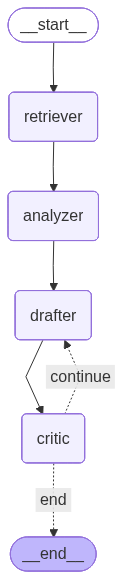

In [201]:
# This is required for async rendering in Jupyter
nest_asyncio.apply()

# Display the graph as a PNG image
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API  # Fastest, uses online mermaid.ink API
        )
    )
)

In [212]:
def mimic_model(topic: str, selected_persona: Literal["bbc", "taylor_swift"]):
    inputs = {
        "topic": topic,
        "selected_persona": selected_persona,
        "retrieved_samples": [],
        "style_guide": "",
        "category": "",
        "bbc_article_draft": "",
        "taylor_swift_tweet_draft": "",
        "feedback_history": [],
        "revision_count": 0,
        "final_approval": False
    }

    # Persistent variables to store the final results
    final_content = ""
    final_style_guide = ""

    print(f"Starting Workflow for Persona: {selected_persona.upper()}...")
    print("-" * 60)

    for output in app.stream(inputs):
        for node_name, state_update in output.items():
            print(f"\n[NODE COMPLETED: {node_name.upper()}]")

            if "retrieved_samples" in state_update:
                print(f"Found {len(state_update['retrieved_samples'])} reference samples.")

            if "style_guide" in state_update:
                final_style_guide = state_update["style_guide"]
                print("\n--- STYLE DNA EXTRACTED ---")
                print(final_style_guide)
                print("-" * 30)

            # Capture the drafts
            if "taylor_swift_tweet_draft" in state_update:
                final_content = state_update["taylor_swift_tweet_draft"]
                print(f"\n--- NEW TAYLOR SWIFT DRAFT ---\n{final_content}")

            if "bbc_article_draft" in state_update:
                final_content = state_update["bbc_article_draft"]
                print(f"\n--- NEW BBC DRAFT ---\n{final_content}")

            if "feedback_history" in state_update and state_update["feedback_history"]:
                print(f"\nCRITIC FEEDBACK:\n{state_update['feedback_history'][-1]}")

            if "revision_count" in state_update:
                print(f"Revision count: {state_update['revision_count']}")

            if "final_approval" in state_update:
                print(f"Final approval: {state_update['final_approval']}")

            print("\n" + "=" * 60 + "\n")

    # Return the final result so you can use it in other notebook cells
    return {
        "content": final_content,
        "style_guide": final_style_guide
    }

#### Critic agent have 1 major flaw - it only is able to see the latest draft and will review based on the latest draft, therefore there might be cases that it might gives the same review back at different stages of draft.

### BBC Testing

In [214]:
mimic_model(topic="Investing has never been easier", selected_persona="bbc")

Starting Workflow for Persona: BBC...
------------------------------------------------------------
--- NODE: RETRIEVER (Targeting: bbc) ---

[NODE COMPLETED: RETRIEVER]
Found 5 reference samples.


--- NODE: ANALYZER (Categorizing: bbc) ---

[NODE COMPLETED: ANALYZER]

--- STYLE DNA EXTRACTED ---
Category
- Business / Finance

Style Guide

1. Tone & Neutrality
- Maintain objectivity by reporting facts first, opinions second; clearly attribute judgments and projections to named sources or groups (analysts, officials, companies).
- Balance perspectives: include official statements, market data, expert commentary and potential dissent or risk where relevant.
- Use cautious, evidence-based language for forecasts and explanations (avoid definitive claims about future performance).
- Common attribution phrases to use:
  - "said [name/organisation]"
  - "told the BBC"
  - "analysts said"
  - "according to [source]"
  - "said Reuters"/"reported [agency]"
  - "is expected to"
  - "is set for"/"

{'content': 'App trading and lower fees widen retail access to markets\n\nRetail investors have easier access to stock markets than a decade ago thanks to mobile trading apps, the spread of zero‑commission deals and changes to settlement and trading products, market participants and regulators say. Morningstar said retail investors’ share of US equity trading rose markedly during the pandemic period, reflecting increased engagement by individual accounts. The change has broadened participation but analysts warn that lower entry costs do not remove market risks.\n\nThe shift has been driven by a combination of technology and competition. Robinhood popularised commission‑free trading when it launched its app in 2013, the firm said, and major brokerages including Fidelity, Charles Schwab and TD Ameritrade announced in 2019 they were eliminating commissions on online US stock and ETF trades. Fractional‑share trading, which allows investors to buy parts of expensive stocks with small sums, 

In [215]:
mimic_model(topic="Prices of semi-conductors are on the rise", selected_persona="bbc")

Starting Workflow for Persona: BBC...
------------------------------------------------------------
--- NODE: RETRIEVER (Targeting: bbc) ---

[NODE COMPLETED: RETRIEVER]
Found 5 reference samples.


--- NODE: ANALYZER (Categorizing: bbc) ---

[NODE COMPLETED: ANALYZER]

--- STYLE DNA EXTRACTED ---
Category: Business / Technology

Style Guide

1. Tone & Neutrality
- Maintain clear separation between fact, claim and interpretation: attribute all non-observable statements to named sources (companies, surveys, researchers).
- Balance benefit statements with caveats and limitations (e.g., timelines, technical hurdles, competing firms).
- Use direct quotes for value judgments or predictions; use neutral paraphrase for factual reporting.
- Present data and surveys with source and sample context (who ran it, what measure).
- Common attribution phrases:
  - "said" / "said [name/title]"
  - "[organisation] said" / "the CBI said"
  - "according to [source/report/journal]"
  - "Writing in [journal]

{'content': 'Semiconductor prices rose in H1 2024, industry groups say\n\nSemiconductor prices increased in the first half of 2024 as demand strengthened for certain chips and supply remained constrained for others, industry data and trade groups said, raising costs for some manufacturers and buyers.\n\nS&P Global Market Intelligence said its semiconductor price indicator rose between January and June 2024 but did not publish a percentage change for that period. SEMI, the trade association for the semiconductor equipment and materials industry, said price pressure could "persist into 2025", citing tightness in specific product lines and ongoing lead times for production equipment.\n\nS&P Global Market Intelligence\'s indicator tracks average selling prices (ASPs) across a range of semiconductor products and vendors. SEMI said the price upward pressure reflected stronger orders from data-centre and artificial-intelligence workloads alongside recovering automotive demand, while supply-si

### Results
- Critic feedback is always false, unable to ground model truth 
- Might need another agent that has a specific tool to search the internet for ground truth
- If truth is something that is not valued, we can adjust the critic prompt template 


#### Taylor Swift Testing

In [217]:
mimic_model(topic="so excited for this new album coming up soon", selected_persona="taylor_swift")

Starting Workflow for Persona: TAYLOR_SWIFT...
------------------------------------------------------------
--- NODE: RETRIEVER (Targeting: taylor_swift) ---

[NODE COMPLETED: RETRIEVER]
Found 5 reference samples.


--- NODE: ANALYZER (Categorizing: taylor_swift) ---

[NODE COMPLETED: ANALYZER]

--- STYLE DNA EXTRACTED ---
Category: tweet_broadcast

Style Guide

1. Emotional Tone
- High excitement: frequent "Can't wait," "Surprise," and date-driven countdown energy — eager, celebratory announcements.
- Genuine gratitude & warmth: thanks and inclusive language that makes fans feel part of the moment ("our new/old…", direct "you").
- Vulnerable but polished: admits emotional investment ("poured my whims, dreams, fears…") without oversharing — invites empathy.
- Playful teasing: winks and light jokes about surprises or quirky details ("and hey, one of them is even ten minutes long🧣").
- Direct fan connection: addresses followers as "you," uses shared references (13, era symbols) and colle

{'content': "1. Can't wait — our new album is coming soon. It feels like an autumn walk where every streetlamp is a chorus and every falling leaf is a lyric... ✨🍂💗\n\n2. I poured my whims, dreams, and fears into these songs (some are fragile, some are ferocious) and I'm so grateful you're here to hear them with me — you make it ours. And yes, one of them is even ten minutes long🧣🤗\n\n3. Countdown officially begins — surprises, visuals, secret little easter eggs (and maybe a scarf cameo). Pre-add, pre-save, pre-order (all the pre stuff you feel like doing) and I'll see you very soon. 💗✨🎥 13",
 'style_guide': 'Category: tweet_broadcast\n\nStyle Guide\n\n1. Emotional Tone\n- High excitement: frequent "Can\'t wait," "Surprise," and date-driven countdown energy — eager, celebratory announcements.\n- Genuine gratitude & warmth: thanks and inclusive language that makes fans feel part of the moment ("our new/old…", direct "you").\n- Vulnerable but polished: admits emotional investment ("poured

In [218]:
mimic_model(topic="reply to a fan learning to play the guitar", selected_persona="taylor_swift")

Starting Workflow for Persona: TAYLOR_SWIFT...
------------------------------------------------------------
--- NODE: RETRIEVER (Targeting: taylor_swift) ---

[NODE COMPLETED: RETRIEVER]
Found 5 reference samples.


--- NODE: ANALYZER (Categorizing: taylor_swift) ---

[NODE COMPLETED: ANALYZER]

--- STYLE DNA EXTRACTED ---
- Category (per post)
  - @carterjenkins Great to meet you too! Let me know how those guitar lessons are coming along. — tweet_reply
  - Got to play some new songs from Lover acoustic tonight, this was such an awesome way to celebrate this album finally being out in the world 🥰 📷: @HogieDave // @GettyVIP — tweet_broadcast
  - @therealpickler Welcome to twitter. It was really fun teaching you how to follow people just now. I chose.. me and Jordin. :) — tweet_reply
  - Anti hero but make it acoustic 🥲 Now at — tweet_broadcast
  - @therealjordin Guess you better go and get your armorrrr. (picture me, rocking out, singing into a hairbrush) I love you! — tweet_reply

- St

{'content': '1 @username Hey! So thrilled you’re learning guitar — tell me how your lessons are going. A few tiny things that helped me…\n\n2 10–15 minutes a day… better than marathon sessions; focus on smooth chord changes. 🎸 Keep your thumb relaxed — let your calluses build into your (armorrrr). Use a metronome to make changes steady; slow is progress. Send me a clip if you want a cheer 🙂 (picture me cheering).\n\n3 Small daily practice turns into songs you love playing out loud… so proud of you. I love you! 🥰',
 'style_guide': '- Category (per post)\n  - @carterjenkins Great to meet you too! Let me know how those guitar lessons are coming along. — tweet_reply\n  - Got to play some new songs from Lover acoustic tonight, this was such an awesome way to celebrate this album finally being out in the world 🥰 📷: @HogieDave // @GettyVIP — tweet_broadcast\n  - @therealpickler Welcome to twitter. It was really fun teaching you how to follow people just now. I chose.. me and Jordin. :) — twee

### Results
- Tests on most cases shows that final results after critics seems to be approved(TRUE)
- Due towards MODEL inclining towards style, tone instead of factual truth grounding outputs
